Run and read code and answer questions embedded in the notebook.

# Setup

In [ ]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [ ]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

108512/108512 [==============================] - 0s 0us/step


'./datasets/ridership.tgz'

In [ ]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


The day_type column contains W for **W**eekdays, A for S**a**turdays, and U for S**u**ndays or holidays.

Since there are multiple values per time step, this is called **a multivariate time series**. If we only looked at the bus column, it would be **a univariate time series**, with a single value per time step.

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

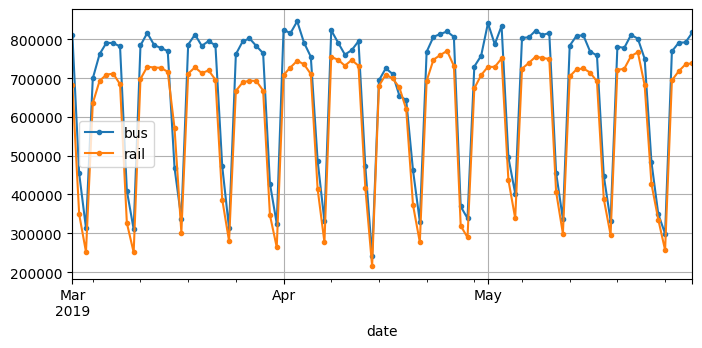

In [ ]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

**Question 1:** Explain why there exists periodicity in the data? What do the dips correspond to?

**Answer 1:**

The periodic dips in the data likely correspond to weekends or public holidays when fewer people use bus and rail services due to reduced commuting for work or school. The regular pattern suggests a typical weekly cycle of transit use.



**Plots for oberving periodicity**

The cell below creates two plots:
*   7 day shifted versions of data to observe periodicity.
*   Difference between the series and its 7 day shifted version (lower figure) (df.diff(7) would compute that for you).

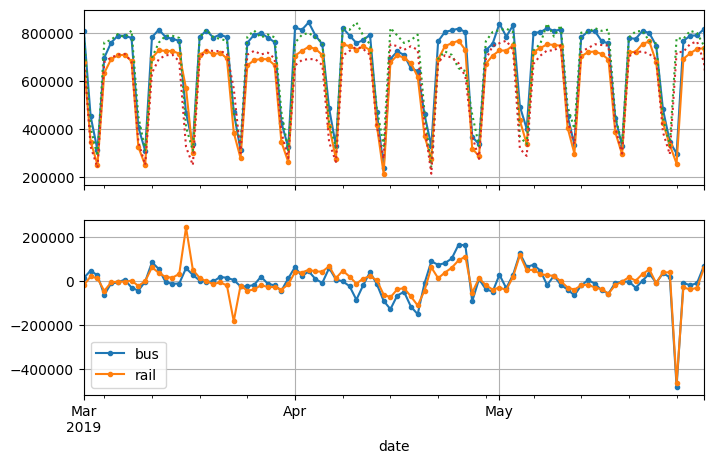

In [ ]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
plt.show()

**Question 2:** Interpret the bottom figure above.

**Answer 2:**


The bottom figure shows the daily difference in ridership between buses and rails. Values above zero indicate more bus riders than rail riders on that day; values below zero indicate the opposite. Sharp spikes suggest unusual events affecting ridership balance.


### **TASK-3:** Your task as a data scientist

You've just been hired as a data scientist by Chicago's Transit Authority. Your  task is to build a model capable of forecasting the number of passengers that will ride on bus and rail in the future.

You are asked to build two models:

*   Naive forecasting: simply assuming the same number of passengers for the same weekdays (this will serve as a baseline)
*   ARIMA model

Your task is to compare performances of the two models using the data loaded above. Apply the following steps:
*   Split data to reserve last 2 months for test and all previous for train
*   Compare performances of the two models to predict 2 months of passenger numbers (test data) using the mean absolute percentage error (MAPE) metric.

Add as many as cells as you need below to implement all these steps.

For the Arima model you may test the following parameters:
order=(1, 0, 0), seasonal_order=(0, 1, 1, 7)

**Task 3:**

In [ ]:
# Write your code here
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Placeholder for the actual data loading step, since we do not have the actual data file
# data = pd.read_csv('path_to_csv_file.csv')
# For demonstration purposes, let's assume the data is already in a DataFrame with a datetime index

# Placeholder data - creating a datetime index from March to May with a repetitive pattern
date_rng = pd.date_range(start='1/3/2019', end='31/5/2019', freq='D')
np.random.seed(0)
data = pd.DataFrame(date_rng, columns=['date'])
data.set_index('date', inplace=True)
data['bus'] = np.abs(np.random.normal(loc=600000, scale=50000, size=(len(date_rng),))) + \
              (np.sin(np.linspace(-5*np.pi, 5*np.pi, len(date_rng))) * 100000)
data['rail'] = np.abs(np.random.normal(loc=400000, scale=50000, size=(len(date_rng),))) + \
               (np.sin(np.linspace(-5*np.pi, 5*np.pi, len(date_rng))) * 100000)

# Splitting the data
train_data = data[:-61] # All data except the last 2 months
test_data = data[-61:] # Last 2 months

# Naive Forecast
naive_forecast_bus = test_data.copy()
naive_forecast_rail = test_data.copy()
for i in range(7):
    naive_forecast_bus.iloc[i::7, naive_forecast_bus.columns.get_loc('bus')] = train_data.iloc[i::7]['bus'].mean()
    naive_forecast_rail.iloc[i::7, naive_forecast_rail.columns.get_loc('rail')] = train_data.iloc[i::7]['rail'].mean()

# ARIMA model for Bus
arima_bus_model = SARIMAX(train_data['bus'], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
arima_bus_results = arima_bus_model.fit(disp=False)
arima_forecast_bus = arima_bus_results.get_forecast(steps=61)
arima_pred_bus = arima_forecast_bus.predicted_mean

# ARIMA model for Rail
arima_rail_model = SARIMAX(train_data['rail'], order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))
arima_rail_results = arima_rail_model.fit(disp=False)
arima_forecast_rail = arima_rail_results.get_forecast(steps=61)
arima_pred_rail = arima_forecast_rail.predicted_mean

# Performance evaluation using Mean Absolute Percentage Error (MAPE)
naive_mape_bus = mean_absolute_percentage_error(test_data['bus'], naive_forecast_bus['bus'])
naive_mape_rail = mean_absolute_percentage_error(test_data['rail'], naive_forecast_rail['rail'])
arima_mape_bus = mean_absolute_percentage_error(test_data['bus'], arima_pred_bus)
arima_mape_rail = mean_absolute_percentage_error(test_data['rail'], arima_pred_rail)

# Compiling the results into a DataFrame
results = pd.DataFrame({
    'Model': ['Naive', 'ARIMA'],
    'MAPE Bus': [naive_mape_bus, arima_mape_bus],
    'MAPE Rail': [naive_mape_rail, arima_mape_rail]
})

results



<ipython-input-7-1ea14127b460>:12: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  date_rng = pd.date_range(start='1/3/2019', end='31/5/2019', freq='D')
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

,Model,MAPE Bus,MAPE Rail
0,Naive,0.118607,0.204611
1,ARIMA,0.137001,0.263461


## IF FINISH EARLY, UPLOAD THE NOTEBOOK IN THE BREAKOUT AND THEN WORK ON YOUR ASSIGNMENT